### Guided Annotation tool
This notebook shows you the whole process of preparing the data which is used as input in the guided annotation tool.
The tool basically shows unlabelled data in the form of explainable clusters to label.
It will show you the following steps:

    1. Load dataset
    2. Train a model and explain it
    3. Perform shap clustering
    4. Save the clusters to database with keywords to be highlighted by the annotation tool

#### Imports

In [10]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cosine

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
# import chart_studio.plotly as py
import seaborn as sns
import shap

### Built-in function usage
To avoid re-writing a lot of stuff for each dataset/model, I have created some functions in the models module/folder.
We are going to use this python module in this tutorial.

In [11]:
import os
os.getcwd()
os.chdir('../')
from models.trainers import Trainer
from app.utils import clear_labels
from models.guided_learning import GuidedLearner
pd.set_option('display.max_colwidth', 1000)

#### View dataset

In [12]:
df = pd.read_csv('datasets/davidson_dataset.csv') # substitute other datasets in similar format
print(df.shape)
df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/davidson_dataset.csv'

In [ ]:
df["label"].hist()

#### Splitting data
  We split data into training, test, pool and individual. Pool is the unlabelled pool we want to generate SHAP clusters for.
  Individual is the bunch of labels we want to get from the user without any guidance
  
  We split as follows: (can be altered)
  70% train
  10% test
  10% pool
  10% individual

In [ ]:
dataset = 'gao_dataset'
t = Trainer(dataset_name=dataset) # the name which you want for the tables in the database
df_train, df_test, df_pool, df_individual = t.train_test_pool_split(df,
                                                                    train_frac=0.4,
                                                                    test_frac=0.1,
                                                                    pool_frac=0.5,
                                                                    unguided='different',
                                                                    stratify=False,
                                                                    )
df_train.shape, df_test.shape, df_pool.shape, df_individual.shape


#### Model fitting


In [ ]:
learner = GuidedLearner(df_train, df_test, df_pool, df_individual, dataset, 1)
tfid, x_train, x_test, x_pool, y_train, y_test, y_pool = learner.tfid_fit()

In [ ]:
model, explainer = learner.grid_search_fit_svc(c=[0.8, 1])

#### Perform shap clustering
We are going to cluster the training data using SHAP explanations (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity.

In [ ]:
df_final_labels, uncertainty, _ = learner.cluster_data_pool(pca=True,
                                                            pca_components=100,
                                                            cluster_sizes=[30],
                                                            cluster_space='shap')

Convert predict probability to uncertainty. In binary classification this would be the same as 1-P

In [10]:
df_final_labels.head()

,text,cluster_id,truth,index1,shaps,keywords
0,I case you havent noticed fucking nothing works under Dim control What is it about the word illegal Dim s do not understand Why do we write laws that are not enforced Vote Trump,0,1.0,0,"[0.025561934042302725, 0.0015624788909411407, 0.04244238985511344, 0.0001428591877955147, 0.00018410706218377446, 0.801618270771222, -0.002131295082275247, -6.889983863246423e-05, 0.0008098406356199507, 0.025561934042302725, 0.0, 0.025561934042302725, -0.013855284720528589, 0.002414084598361779, -0.005153863822996208, 0.025561934042302725, -0.0005331489674924961, -0.0021509539088462684, 0.025561934042302725, 0.025561934042302725, 7.321631826287681e-05, -0.0007392405015900389, 0.0, 0.025561934042302725, 7.321631826287681e-05, -0.016930433902921354, 0.0, -0.0011136766818381713, 0.05321729564323777, 0.046322425899248974, -0.0007392405015900389, 0.0, 0.025561934042302725, 0.025561934042302725]",fucking
1,Democrats sure cant fix anything and they fucking sure can keep information secure but they sure can empty a liquor store and burn it to the ground completely easy enough,0,1.0,1,"[-0.06674844281816691, -0.006279930276354401, -0.008775676552287759, -0.0003640730763545483, 0.0017365377031160385, -0.0321565360360371, 0.0032049335765002005, -0.20897310484469928, -0.006279930276354401, 0.0014379401382795438, -0.0007465188343871047, -0.0008301015012073359, -0.0002729770118849267, -0.003820680546681712, 0.0032049335765002005, -0.006279930276354401, 0.0014379401382795438, -0.000591825174416432, -0.06674844281816691, -0.0015685591112758555, -0.0010150217977590052, -0.0321565360360371, -0.0010008394480514758, 0.002414084598361779, -0.0009046811817901585, -0.06674844281816691, -0.000931762201866621, -0.000591825174416432, -0.0007243104446593688, 0.00028175068881544846]",fucking
2,BLM is a terrorist organization funded by the left As a prominent fucking member of the left Alan you should know this So call all your Jewish friends like Soros and tell them to stop sending the checks Good luck with that,0,1.0,2,"[-0.06674844281816691, -0.013855284720528589, -0.06674844281816691, 0.0, 0.0, -0.0, -0.005396891603861549, -0.06674844281816691, -0.0005000791276146221, -0.06674844281816691, -0.06674844281816691, 0.0, -0.20897310484469928, 0.0, -0.01238680917820576, -0.06674844281816691, -0.0005000791276146221, -0.06674844281816691, 0.04244238985511344, 0.0023131471211720236, -0.002235814157358202, -0.015847205636599474, -0.06674844281816691, -0.0, -0.0015623002595957947, 0.017325383709436402, -0.06674844281816691, 0.0, 0.002744542544562691, -0.06674844281816691, -0.0321565360360371, 0.0, -0.005996197785446594, -0.0009046811817901585, -0.001702026378475969, 0.0, -0.06674844281816691, 0.0, -0.06674844281816691, 0.0, -0.005697247230425401, -0.013257151220139277]",fucking
3,DemocRats love illegals fucking why you may ask because they can round them up and have them vote in elections Only Grubers believe there is no voter fraud yes the dead do vote in Chicago,0,1.0,3,"[-0.06674844281816691, 0.0, -0.001878374217087795, -0.20897310484469928, 0.0008870276662114992, 0.04244238985511344, 0.0, 0.0, -0.007779041189880864, 0.0032049335765002005, 0.0014379401382795438, 0.0, -0.005996197785446594, -0.000559273420749531, 0.0743833278709958, 0.013893313267151743, -0.005996197785446594, -0.0036862372669794943, -0.016271174384082588, -2.069240178752307e-05, -0.06674844281816691, -0.06674844281816691, -0.0, 0.0029675404063010994, -0.013855284720528589, -0.015432847247681814, 0.0, -0.00018595537433312566, 0.0, -0.06674844281816691, -0.0, 7.321631826287681e-05, -0.0036862372669794943, -0.016271174384082588, -0.06674844281816691]",fucking
4,How embarrassing for the fucking Navy and America Liberals have gleefully embraced every known perversion and deviance and are angry that sane people refuse to accept their sickness as normal Liberals the very worst among us Liberalism America s greatest enemy,0,1.0,4,"[0.0472217680777639, 0.0472217680777639,

In [10]:
learner.save_to_db(df_final_labels)

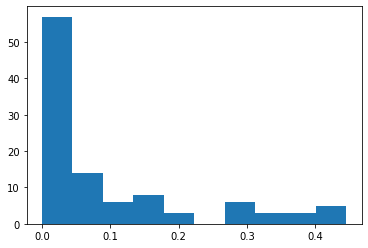

In [11]:
plt.hist(uncertainty)
plt.show()

#### Additional explanations

With saving to database, all your steps for the guided annotations are complete.
In this section, we show you how to look at explanations of a single instance

In [12]:
predictions = model.predict(x_pool)

In [13]:
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_pool)

In [14]:
shap_values_pool.shape

(151, 2855)

In [15]:
df_test.head()

,index,label,text,processed
681,1417.0,0.0,There you go thinking again Please leave it to people equipped and qualified to do it correctly,There you go thinking again Please leave it to people equipped and qualified to do it correctly
1065,1252.0,1.0,Unfortunately being too fat from eating like fucking a pig is considered a disability especially in the black community I have never seen a skinny person using an EBT card Not saying skinny ones dont exist I just have never seen one,Unfortunately being too fat from eating like fucking a pig is considered a disability especially in the black community I have never seen a skinny person using an EBT card Not saying skinny ones dont exist I just have never seen one
265,861.0,0.0,Lots of laughs,Lots of laughs
572,1271.0,0.0,I get the impression that the German people really didnt have much of a say in it Just another of example of Merkel Obama progressivness,I get the impression that the German people really didnt have much of a say in it Just another of example of Merkel Obama progressivness
728,79.0,1.0,The socialists want to increase income diversity political fucking speak for steal from whites and give to non whites I have a better idea All whites boycott the schools who feel they have to discriminate against whites See how long all minority schools stay in business,The socialists want to increase income diversity political fucking speak for steal from whites and give to non whites I have a better idea All whites boycott the schools who feel they have to discriminate against whites See how long all minority schools stay in business


Explain a single positive prediction at 'index'

text  Unfortunately being too fat from eating like fucking a pig is considered a disability especially in the black community  I have never seen a skinny person using an EBT card  Not saying skinny ones dont exist I just have never seen one   prediction:  1.0 actual  1.0


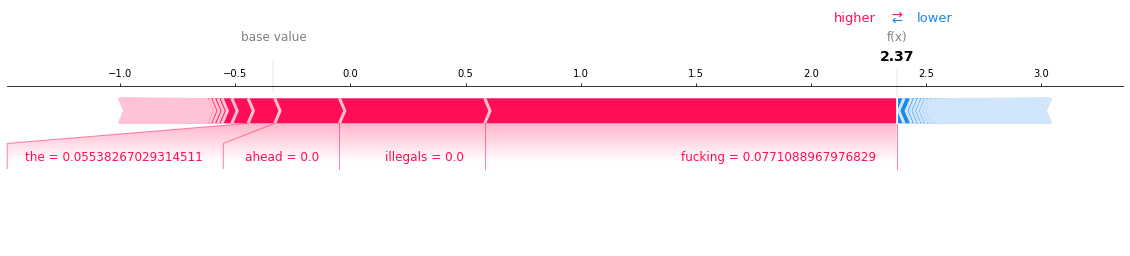

In [16]:
postive_index = 0
index = np.where(predictions==1)[0][postive_index]
print("text ", df_test["text"].values[index], " prediction: ", predictions[index], "actual ", y_test[index])
shap.force_plot(explainer.expected_value, 
                               shap_values_pool[index,:], 
                               x_test[index,:], feature_names = tfid.get_feature_names(),
               matplotlib=True)

In [23]:
df_final_labels.head()

,text,cluster_id,positive,negative,keywords,truth,round
0,doesnt work i cant even fucking count the number of times i ve heard people say they dont care if they get fucking pregnant again or have another kid thats just a pay raise to them,0,fucking,another,fucking,1.0,1
1,Methuen Feminism is fucking cancer,0,fucking,the,fucking,1.0,1
2,Water buffalo LOL fucking Perfect,0,fucking,lol,fucking,1.0,1
3,Spoken like a true fucking Wookie,0,fucking,like,fucking,1.0,1
4,Just mowing down future terrorist Keep it up fucking Israel,0,fucking,israel,fucking,1.0,1


In [26]:
learner.save_to_db(df_final_labels)